# По полученным в прошлом задании эмбеддингам будем учить RNN на задачу классификации последовательности
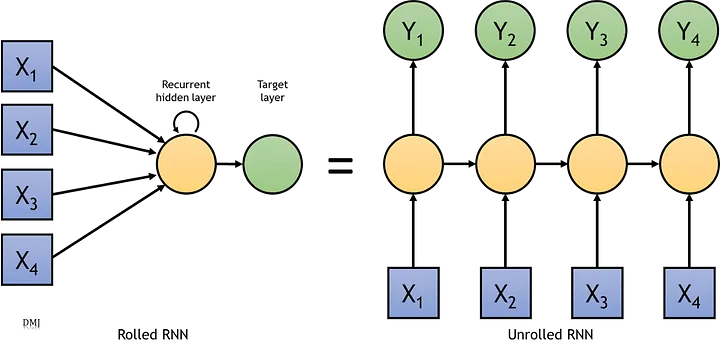

In [315]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import time
import copy
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import  word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Подгрузка данных, полученных в прошлой задаче

In [510]:
SEQ_SIZE = 45
BATCH_SIZE = 64
EPOCHS = 12
MOMENTUM = 0.9

In [4]:
text = pd.read_csv('inetensive_1.csv')
text.head()

,Unnamed: 0,text,label
0,0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,4,"Oil prices soar to all-time record, posing new...",2


In [6]:
with open('word_set.pkl', 'rb') as fp:
    word_set = pickle.load(fp)
    

In [54]:
with open('sentences.pkl', 'rb') as fp:
    sentences = pickle.load(fp)

In [9]:
with open('tok2id.pkl', 'rb') as fp:
    tok2id = pickle.load(fp)

In [17]:
tok2id['forest']

35598

In [18]:
with open('id2tok.pkl', 'rb') as fp:
    id2tok = pickle.load(fp)

In [19]:
id2tok[35598]

'forest'

In [21]:
encode_vecs = np.load('encode_vecs.npy')

In [24]:
encode_vecs = encode_vecs.T

In [25]:
encode_vecs[35598]

array([-0.35168386,  0.21313487,  0.23739396,  0.11596899, -0.24573512,
       -0.13950878, -0.06124759,  0.3099019 , -0.44854644, -0.28055656,
        0.21535856, -0.33780754,  0.10278979, -0.11188027,  0.32052532,
        0.20496215, -0.11142376, -0.67078555,  0.06223183,  0.2506867 ,
       -0.35540533, -0.2533226 , -0.46387938, -0.54268986, -0.11586326,
       -0.2853594 , -0.12736358,  0.29690194, -0.09296357,  0.35541704,
       -0.15181017,  0.6673438 , -0.42016584, -0.24368076,  0.03700854,
       -0.13588466,  0.22790174,  0.3525074 , -0.09487161, -0.23008633,
       -0.15816492, -0.25315732,  0.49222776, -0.42388445, -0.11065239,
       -0.47813568,  0.29523167,  0.46098173,  0.34166777,  0.19028541,
        0.03243041, -0.06598742, -0.23589   , -0.20221443, -0.08048113,
       -0.24307683,  0.37872174,  0.00935345,  0.1788547 , -0.07176269,
        0.23564896, -0.14758952, -0.00737387,  0.36409467,  0.6129809 ,
        0.04156582, -0.7164911 ,  0.6341502 ,  0.16763295,  0.14

## Сделаем отдельные токены, которые будут отвечать за начало/конец последовательности, паддинг и неизвестные обученному word2vec слова

In [36]:
VOCAB_SIZE = encode_vecs.shape[0]
UNK_IDX = int(encode_vecs.shape[0])
PAD_IDX = int(encode_vecs.shape[0]) + 1
EOS_IDX = int(encode_vecs.shape[0]) + 2
BOS_IDX = int(encode_vecs.shape[0]) + 3

In [42]:
VOCAB_SIZE += 2

In [38]:
PAD_IDX

59996

In [ ]:
encode_vecs = torch.cat((torch.from_numpy(encode_vecs),  torch.zeros((4, 300))))

In [52]:
encode_vecs.shape

torch.Size([59999, 300])

## Посмотрим на предложения и их длины

In [63]:
print(sentences[0])
print(text['label'][0])
s = []
for x in sentences:
  s.append(len(x))
s.sort(reverse=True)
print('max len of sentence:', s[0])
print('mean len of sentence:', np.mean(s))

['wall', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'wall', 'street', 'of', 'are', 'seeing', 'green', 'again']
2
max len of sentence: 176
mean len of sentence: 35.902483333333336


## Обрежем или добавим паддинг к предложениям так, чтобы длина вместе с <BOS> и <EOS> была 47

In [89]:
def trunkate(sent):
    x = sent.copy()
    if len(x) >= SEQ_SIZE:
        x = x[:SEQ_SIZE]
    if len(x) < SEQ_SIZE:
        while len(x) < SEQ_SIZE:
            x.append('<PAD>')
    x.insert(0, '<BOS>')
    x.append('<EOS>')
    return x

In [90]:
trunkate(sentences[0])

['<BOS>',
 'wall',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 'reuters',
 'reuters',
 'wall',
 'street',
 'of',
 'are',
 'seeing',
 'green',
 'again',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<EOS>']

In [91]:
sentences_tr = [trunkate(sent) for sent in sentences]

In [211]:
mask = []

## Переведем слова в их индексы, соответсвующие обученному word2vec, чтобы потом использовать слой nn.Embedding.from_pretrained(weights)

In [212]:
def seq_to_idx_list(sent, mask):
    res = []
    mask_ = []
    for w in sent:
        if w == "<PAD>":
            mask_.append(0) 
            res.append(PAD_IDX)
        elif w == "<BOS>":
            res.append(SOS_IDX) 
            mask_.append(1)
        elif w == "<EOS>":
            res.append(EOS_IDX)
            mask_.append(1)
        elif w not in word_set:
            res.append(UNK_IDX)
            mask_.append(1)
        else:
            res.append(tok2id[w])
            mask_.append(1)
    mask.append(mask_)    
    return res

In [214]:
sentences_idx = [seq_to_idx_list(sent, mask) for sent in tqdm(sentences_tr)]

100%|██████████| 120000/120000 [00:02<00:00, 41411.74it/s]


## Датасет, разделение и даталоадер

In [111]:
from torch.utils.data import Dataset, DataLoader

In [269]:
class IndexesDataset(Dataset):

    def __init__(self, dataset, labels, masks):
        self.dataset = dataset
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # dataset[idx]
        text = self.dataset[idx]
        label = self.labels[idx]
        mask = self.masks[idx]
        sample = {'data': text, 'label': label, 'mask': mask}
        return sample

In [286]:
sentences_idx = np.array(sentences_idx)
labels = np.array(text['label'])
masks = np.array(mask)

In [463]:
dataset = IndexesDataset(sentences_idx, labels, masks)

In [464]:
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*4/5), len(dataset) - int(len(dataset)*4/5)])

In [465]:
train_dl = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
val_dl = DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [466]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [292]:
NUM_CLASSES = len(text['label'].unique())

## Класс модели
## Будем брать контактенацию hidden токекенов и отправлять дальше на классификацию в линейные слои

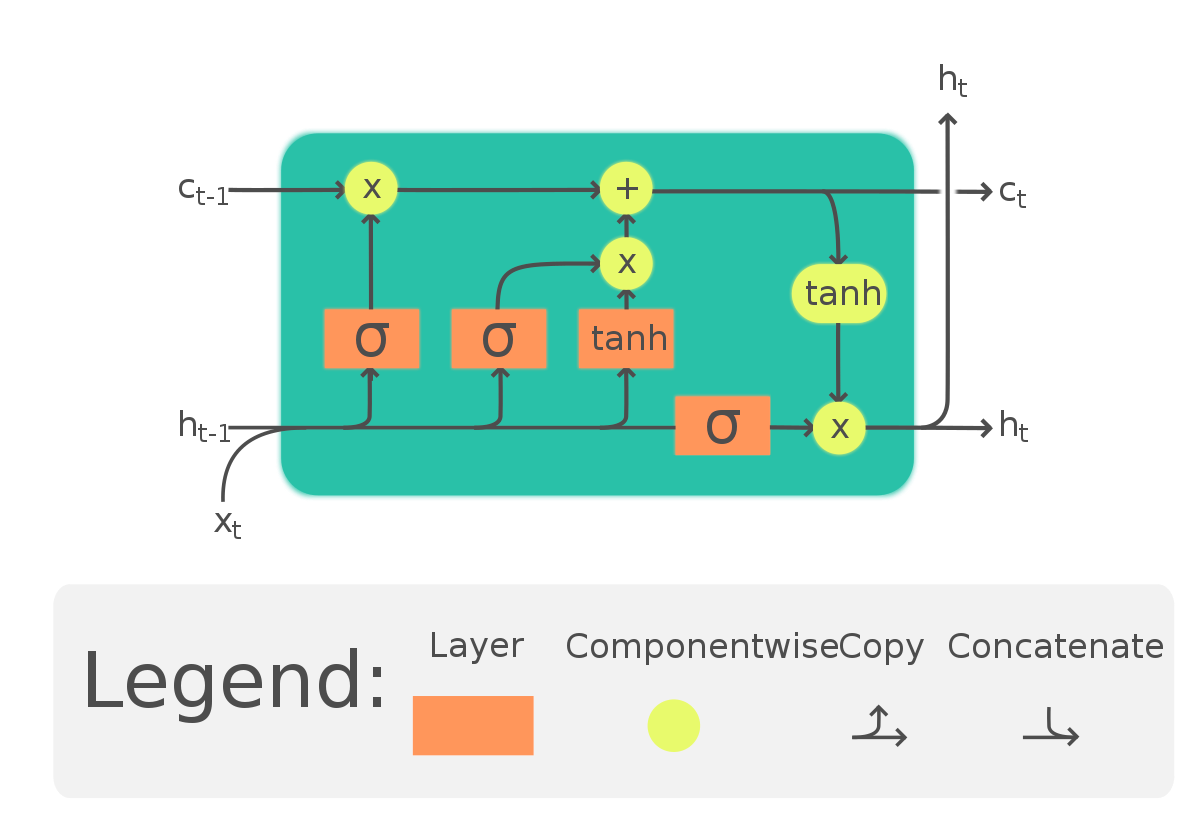

In [512]:
class LstmClassifier(nn.Module):
  
    def __init__(self, hidden_dim, output_dim=4, embedding_dim=300, batch_first=True, drop_prob=0.2, num_layers=2, bidirectional=True):
        super(LstmClassifier, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(encode_vecs, padding_idx=PAD_IDX, freeze=True) # wherever you have an item equal to padding_idx,
                                                                                                     # the output of the embedding layer at that index will be all zeros
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=batch_first, dropout=drop_prob, bidirectional=bidirectional)
        # self.linear = nn.Linear(hidden_dim, output_dim)
        self.linear1 = nn.Linear(hidden_dim*2, output_dim*2)
        self.batch_norm = nn.BatchNorm1d(output_dim*2)
        self.linear2 = nn.Linear(output_dim*2, output_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(drop_prob)
        self.bidirectional = bidirectional
    
    def forward(self, x, hidden):
        # text = [sent len, batch size]
        embedded = self.embedding(x)
        # output, hidden = self.rnn(embedded, h)
        output, (hidden_state,cell_state) = self.rnn(embedded, hidden)
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        # output = self.linear(output) # one linear/dense
        output = self.linear1(hidden)
        output = self.batch_norm(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)     
        return output, (hidden_state,cell_state)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers*(self.bidirectional*2), batch_size, self.hidden_dim, device=device), torch.zeros(self.num_layers*(self.bidirectional*2), batch_size, self.hidden_dim, device=device))
        

In [523]:
model = LstmClassifier(hidden_dim=128, output_dim=NUM_CLASSES, num_layers=2, bidirectional=True) # bs 16, hidden_dim 128, 2 layers, 20 epoch, dropout 0.2
print(model)
model = model.to(device)

LstmClassifier(
  (embedding): Embedding(59999, 300, padding_idx=59996)
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (linear1): Linear(in_features=256, out_features=8, bias=True)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Проверим выходы h_t и h_n у модели

In [412]:
model.eval()

LstmClassifier(
  (embedding): Embedding(59999, 300, padding_idx=59996)
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (linear1): Linear(in_features=256, out_features=8, bias=True)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [418]:
t = torch.rand(16, 47, 300) # 16 - батч, 47 - количество слов в предложении, 300 - длина эмбеддинга

In [419]:
h, c =  model.init_hidden(BATCH_SIZE) # инициализация хиддена

In [421]:
out, hidden = model.rnn(t.to(device), (h.to(device), c.to(device)))

In [428]:
out.shape

torch.Size([16, 47, 256])

In [424]:
hidden[0].shape

torch.Size([4, 16, 128])

In [427]:
hidden[1].shape

torch.Size([4, 16, 128])

https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html#torch.nn.utils.rnn.pack_padded_sequence   
Можно в другой раз попробовать pack_padded_sequence   
        # Thanks to packing, LSTM don't see padding tokens    
        # and this makes our model better

In [524]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=MOMENTUM)

In [433]:
def accuracy(preds, y):
    #round predictions to the closest integer
    correct = (preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

## Обучение

In [525]:
dataloaders = {'train': train_dl,
               'val': val_dl}

all_tr_loss = np.zeros(EPOCHS)
all_tr_acc = np.zeros(EPOCHS)
all_val_loss = np.zeros(EPOCHS)
all_val_acc = np.zeros(EPOCHS)
best_loss_val = 99
for e in range(EPOCHS):
    for mode in ['train', 'val']:
        if mode == 'train':
            epoch_loss['val'] = 0.0
            epoch_acc['val'] = 0.0
            epoch_loss['train'] = 0.0
            epoch_acc['train'] = 0.0  
  
#         epoch_loss = {'train': 0.0, 'val': 0.0}
#         epoch_acc = {'train': 0.0, 'val': 0.0}
        if mode == 'train':
            model.train()
        else:
            model.eval()
        # h0 =  model.init_hidden(BATCH_SIZE)
        hidden =  model.init_hidden(BATCH_SIZE)
#         hidden.to(device)
#         h = h.to(device)
#         c = c.to(device)
        h = tuple([e.data for e in hidden])
        b_losses = []  # batch losses
        b_accs = []
        for batch_idx, batch in enumerate(dataloaders[mode]):
            input_ = (batch['data']).to(dtype=torch.long, device=device)
            target = (batch['label']).to(dtype=torch.long, device=device)
            

            optimizer.zero_grad()
            with torch.set_grad_enabled(mode == 'train'):
                h = tuple([e.data for e in h])

                out, h  = model(input_, h) 
#                 out = out[:, -1]
#                 print(out.shape)
#                 print(target.shape)
                loss = criterion(out, target)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
            b_losses.append(loss.item())
            preds = out.max(dim=1)[1]
            acc = accuracy(preds, target)
            b_accs.append(acc.item())
                    
        epoch_loss[mode] = np.mean(b_losses)
        epoch_acc[mode] = np.mean(b_accs)
        if mode == 'val':
            if epoch_loss['val'] < best_loss_val:
              best_loss_val = epoch_loss['val']
              torch.save(model.state_dict(), 'lstm_best.pt')
    
    print(f"Epoch {e+1}", f"train loss ----- {epoch_loss['train']}")
    all_tr_loss[e] = epoch_loss['train']
    print(f"Epoch {e+1}", f"train acc ----- {epoch_acc['train']}")
    all_tr_acc[e] = epoch_acc['train']
    print('-------------------------------------------')
    print(f"Epoch {e+1}", f"val loss ----- {epoch_loss['val']}")
    all_val_loss[e] = epoch_loss['val']
    print(f"Epoch {e+1}", f"val acc ----- {epoch_acc['val']}")
    all_val_acc[e] = epoch_acc['val']
    print('-------------------------------------------')
    print('-------------------------------------------')
    

Epoch 1 train loss ----- 0.5005781807104747
Epoch 1 train acc ----- 0.835375
-------------------------------------------
Epoch 1 val loss ----- 0.308707754055659
Epoch 1 val acc ----- 0.897625
-------------------------------------------
-------------------------------------------
Epoch 2 train loss ----- 0.36717097065846127
Epoch 2 train acc ----- 0.8778020833333333
-------------------------------------------
Epoch 2 val loss ----- 0.28451169294118883
Epoch 2 val acc ----- 0.9022083333333333
-------------------------------------------
-------------------------------------------
Epoch 3 train loss ----- 0.3230387941946586
Epoch 3 train acc ----- 0.8908854166666667
-------------------------------------------
Epoch 3 val loss ----- 0.25950790544350943
Epoch 3 val acc ----- 0.9109166666666667
-------------------------------------------
-------------------------------------------
Epoch 4 train loss ----- 0.2911564262757699
Epoch 4 train acc ----- 0.9032604166666667
-------------------------

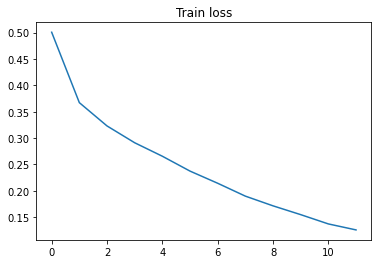

In [526]:
plt.plot(all_tr_loss)
plt.title('Train loss')
plt.show()

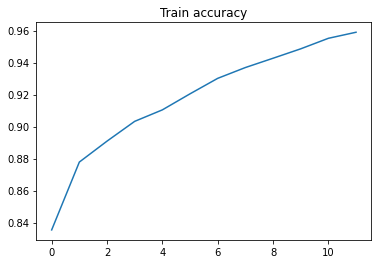

In [527]:
plt.plot(all_tr_acc)
# plt.plot.title('val acc')
plt.title('Train accuracy')
plt.show()

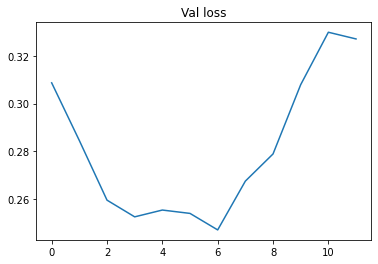

In [528]:
plt.plot(all_val_loss)
plt.title('Val loss')
plt.show()

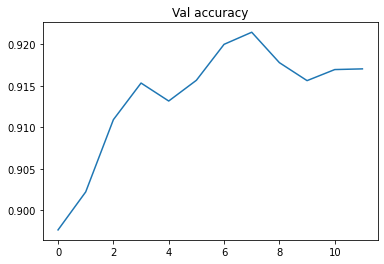

In [529]:
plt.plot(all_val_acc)
# plt.plot.title('val acc')
plt.title('Val accuracy')
plt.show()

In [530]:
best_loss_val

0.24702544676760832

In [533]:
max(all_val_acc)

0.9214583333333334

Прошлые результаты

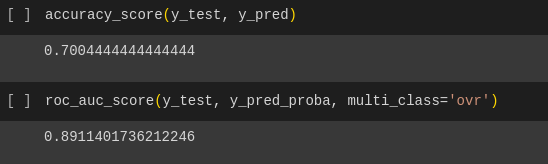
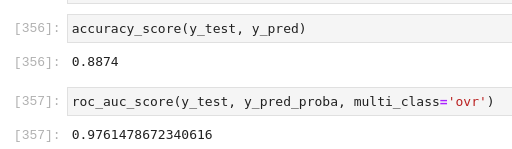